In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
using HomotopyContinuation
using Parameters
using Plots
using BenchmarkTools
using Symbolics
using LinearAlgebra

In [44]:
include(srcdir("NetworkTopologies.jl"))

3×4 Matrix{Int64}:
  0   0  0  1
 -1   1  0  0
 -1  -1  1  0

In [3]:
# include(srcdir("TissueModel_Hill.jl"))
# include(srcdir("Evolution.jl"))

function create_morph(p,x)
    new = copy(p)
    new[end] = x

    return new
end

function get_pos_real_solutions(r)
    return filter(s -> all(s .> 0), real_solutions(r))
end

get_pos_real_solutions (generic function with 1 method)

In [4]:
@var G1,G2,G3

# @var A1,A2,A3

@var M

@var W11,W12,W13,W21,W22,W23,W31,W32,W33

@var W1M,W2M,W3M

@var λ_G;

In [5]:
SteadyStates = [((W11*G1 + W12*G2 + W13*G3 + W1M*M)^2 + 1)*(2*λ_G*G1 - 1)^2 - (W11*G1 + W12*G2 + W13*G3 + W1M*M)^2,
                ((W21*G1 + W22*G2 + W23*G3 + W2M*M)^2 + 1)*(2*λ_G*G2 - 1)^2 - (W21*G1 + W22*G2 + W23*G3 + W2M*M)^2,
                ((W31*G1 + W32*G2 + W33*G3 + W3M*M)^2 + 1)*(2*λ_G*G3 - 1)^2 - (W31*G1 + W32*G2 + W33*G3 + W3M*M)^2,
]

# SteadyStates = [(W11*G1 + W12*G2 + W13*G3 + W1M*M) + A1*(1 - 2*λ_G*G1),
#                 (W21*G1 + W22*G2 + W23*G3 + W2M*M) + A2*(1 - 2*λ_G*G2),
#                 (W31*G1 + W32*G2 + W33*G3 + W3M*M) + A3*(1 - 2*λ_G*G3),
#                 A1^2 - (W11*G1 + W12*G2 + W13*G3 + W1M*M)^2 - 1, 
#                 A2^2 - (W21*G1 + W22*G2 + W23*G3 + W2M*M)^2 - 1, 
#                 A3^2 - (W31*G1 + W32*G2 + W33*G3 + W3M*M)^2 - 1, 
# ]

3-element Vector{Expression}:
 (-1 + 2*G1*λ_G)^2*(1 + (G1*W11 + G2*W12 + G3*W13 + M*W1M)^2) - (G1*W11 + G2*W12 + G3*W13 + M*W1M)^2
 (-1 + 2*G2*λ_G)^2*(1 + (G1*W21 + G2*W22 + G3*W23 + M*W2M)^2) - (G1*W21 + G2*W22 + G3*W23 + M*W2M)^2
 (-1 + 2*G3*λ_G)^2*(1 + (G1*W31 + G2*W32 + G3*W33 + M*W3M)^2) - (G1*W31 + G2*W32 + G3*W33 + M*W3M)^2

In [6]:
@variables g1,g2,g3,m

@variables w11,w12,w13,w21,w22,w23,w31,w32,w33

@variables w1m,w2m,w3m

@variables λ_g;

g1_f(g1,g2,g3) = 0.5*(((w11*g1 + w12*g2 + w13*g3 + w1m*m)/sqrt((w11*g1 + w12*g2 + w13*g3 + w1m*m)^2 + 1)) + 1) - λ_g*g1
g2_f(g1,g2,g3) = 0.5*(((w21*g1 + w22*g2 + w23*g3 + w2m*m)/sqrt((w21*g1 + w22*g2 + w23*g3 + w2m*m)^2 + 1)) + 1) - λ_g*g2
g3_f(g1,g2,g3) = 0.5*(((w31*g1 + w32*g2 + w33*g3 + w3m*m)/sqrt((w31*g1 + w32*g2 + w33*g3 + w3m*m)^2 + 1)) + 1) - λ_g*g3

g3_f (generic function with 1 method)

In [7]:
J = Symbolics.jacobian([g1_f(g1,g2,g3), g2_f(g1,g2,g3),g3_f(g1,g2,g3) ], [g1,g2,g3])

J_call = eval(Symbolics.build_function(J,[g1,g2,g3,w11, w21, w31, w12, w22, w32, w13, w23, w33, w1m, w2m, w3m, λ_g, m])[1])

# eigvals(J_call(rand(17)))


#11 (generic function with 1 method)

In [336]:
const Nc = 100
const Ng = 3
const L = 1.
const θ = 5.
const c0 = 10.
const λm = 0.4

const tissue = range(0,L,length = Nc)

mor(x) = c0*exp(-x/λm)
σ(I) = 0.5*((I/sqrt(I^2+1)) + 1)

function system(G,p)

    G1 = G[1]
    G2 = G[2]
    G3 = G[3]

    w11, w21, w31, w12, w22, w32, w13, w23, w33, w1m, w2m, w3m, λ_g, M = p

    # r1 = 0.5*(((w11*G1 + w12*G2 + w13*G3 + w1m*M)/sqrt((w11*G1 + w12*G2 + w13*G3 + w1m*M)^2 + 1)) + 1) - λ_g*G1
    # r2 = 0.5*(((w21*G1 + w22*G2 + w23*G3 + w2m*M)/sqrt((w21*G1 + w22*G2 + w23*G3 + w2m*M)^2 + 1)) + 1) - λ_g*G2
    # r3 = 0.5*(((w31*G1 + w32*G2 + w33*G3 + w3m*M)/sqrt((w31*G1 + w32*G2 + w33*G3 + w3m*M)^2 + 1)) + 1) - λ_g*G3

    r1 = σ(w11*G1 + w12*G2 + w13*G3 + w1m*M) - λ_g*G1
    r2 = σ(w21*G1 + w22*G2 + w23*G3 + w2m*M) - λ_g*G2
    r3 = σ(w31*G1 + w32*G2 + w33*G3 + w3m*M) - λ_g*G3

    eig = J_call([G1,G2,G3,w11, w21, w31, w12, w22, w32, w13, w23, w33, w1m, w2m, w3m, λ_g, M])

    return all(abs.([r1,r2,r3]) .< 1e-10) && all(real.(eigvals(eig)) .< 0)
end

function eig_sys(G,p)

    G1 = G[1]
    G2 = G[2]
    G3 = G[3]

    w11, w21, w31, w12, w22, w32, w13, w23, w33, w1m, w2m, w3m, λ_g, M = p

    eig = J_call([G1,G2,G3,w11, w21, w31, w12, w22, w32, w13, w23, w33, w1m, w2m, w3m, λ_g, M])

    return eigvals(eig)
end

function zero_sys(G,p)

    G1 = G[1]
    G2 = G[2]
    G3 = G[3]

    w11, w21, w31, w12, w22, w32, w13, w23, w33, w1m, w2m, w3m, λ_g, M = p

    r1 = σ(w11*G1 + w12*G2 + w13*G3 + w1m*M) - λ_g*G1
    r2 = σ(w21*G1 + w22*G2 + w23*G3 + w2m*M) - λ_g*G2
    r3 = σ(w31*G1 + w32*G2 + w33*G3 + w3m*M) - λ_g*G3

    return abs.([r1,r2,r3])
end

zero_sys (generic function with 1 method)

In [337]:
GRN = System(SteadyStates,
           parameters =
           [W11; W21; W31; W12; W22; W32; W13; W23; W33; W1M; W2M; W3M; λ_G; M ])

System of length 3
 3 variables: G1, G2, G3
 14 parameters: W11, W21, W31, W12, W22, W32, W13, W23, W33, W1M, W2M, W3M, λ_G, M

 (-1 + 2*G1*λ_G)^2*(1 + (G1*W11 + G2*W12 + G3*W13 + M*W1M)^2) - (G1*W11 + G2*W12 + G3*W13 + M*W1M)^2
 (-1 + 2*G2*λ_G)^2*(1 + (G1*W21 + G2*W22 + G3*W23 + M*W2M)^2) - (G1*W21 + G2*W22 + G3*W23 + M*W2M)^2
 (-1 + 2*G3*λ_G)^2*(1 + (G1*W31 + G2*W32 + G3*W33 + M*W3M)^2) - (G1*W31 + G2*W32 + G3*W33 + M*W3M)^2

In [338]:
# w =    [2.97517   0.0438774  -1.01647   -1.20823;
# -2.08552  -2.02633     8.21438    0.0;
# -4.62652  -0.556583   -0.396577   0.0]

# w = [0.0 0.0 0.0 0.979431;
# -0.840603 0.0 0.231757 0.0;
#  0.0 -0.475838 0.637345 0.0]

# w = 10 .* (rand(3,4) .- rand(3,4))
# w[2,4] = 0.
# w[3,4] = 0.

start_topology = w_frozen_osc

w = (0.9995 .^ rand(0:10000,Ng,Ng+1)) .* 10 .* rand(Ng,Ng+1) .* start_topology

w = [ 0.567407  -1.40317     -0.171388  1.51779;
 0.0        0.00521438   0.0       0.0;
 0.166203  -0.71488      0.0       0.0]

weights = w[:]

p = zeros(length(weights)+2)

p[1:end-2] = weights
p[end-1] = 0.05
p[end] = 10.

morphogen_gradient = [create_morph(p,mor(x)) for x in tissue];

p = morphogen_gradient[1]

S = solve(GRN, target_parameters = p);

In [339]:
function solve_set(set,system)

    sol = []

    for p_i in set

        S = solve(system,target_parameters = p_i)

        push!(sol,get_valid_solutions(S,p_i))

    end

    return sol
    
end

solve_set (generic function with 1 method)

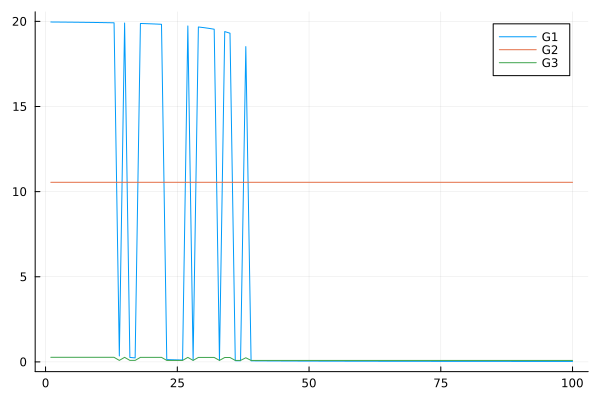

In [340]:
sol_alt = solve_set(morphogen_gradient,GRN);

d1 = map(y->y[1],filter(x->length(x) > 0,sol_alt))

plot(map(x->x[1],d1),label = "G1")
plot!(map(x->x[2],d1),label = "G2")
plot!(map(x->x[3],d1),label = "G3")

In [299]:
r = get_pos_real_solutions(S)

10-element Vector{Vector{Float64}}:
 [19.94832608808777, 9.504981753320042, 19.610943706455874]
 [19.928220986067068, 10.549247507795387, 19.731669161519484]
 [4.059002678472328, 9.504981753320013, 19.869132083424812]
 [4.039517520030925, 10.5492475077954, 19.89571709751204]
 [0.6315725925059638, 10.5492475077954, 19.910794040793483]
 [6.092590029277243, 10.5492475077954, 19.88472434725302]
 [1.8476031626073441, 10.549247507795407, 0.09418872516619059]
 [19.97101588753802, 9.504981753320033, 0.3898522484517526]
 [0.8328852098871637, 9.504981753320017, 0.11096929563831368]
 [19.963404813616812, 10.549247507795396, 0.269044656025182]

In [300]:
g

3-element Vector{Float64}:
  0.06158915633284866
 10.549247507795332
  0.0870048994454541

In [301]:
map(x->system(x,p),r)

10-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1

In [302]:
map(x->zero_sys(x,p),r)

10-element Vector{Vector{Float64}}:
 [5.551115123125783e-16, 0.04950182466799763, 0.9610943706455874]
 [4.440892098500626e-16, 9.992007221626409e-16, 0.973166916151949]
 [0.594099732152759, 0.04950182466799902, 0.9869132083424814]
 [9.2148511043888e-15, 4.440892098500626e-16, 0.9895717097512042]
 [9.020562075079397e-17, 4.440892098500626e-16, 0.9910794040793485]
 [0.39074099707224513, 4.440892098500626e-16, 0.988472434725302]
 [0.8152396837392624, 1.1102230246251565e-16, 2.168404344971009e-17]
 [3.3306690738754696e-16, 0.04950182466799807, 2.0816681711721685e-17]
 [0.9167114790112832, 0.04950182466799885, 4.5102810375396984e-17]
 [6.661338147750939e-16, 5.551115123125783e-16, 2.0816681711721685e-17]

In [303]:
map(x->real.(eig_sys(x,p)) .< 0 ,r)

10-element Vector{BitVector}:
 [1, 1, 1]
 [1, 1, 1]
 [1, 1, 0]
 [1, 1, 0]
 [1, 1, 1]
 [1, 1, 0]
 [1, 1, 0]
 [1, 1, 1]
 [1, 1, 1]
 [1, 1, 1]

In [304]:
function get_valid_solutions(r,p)
    rp = filter(s -> all(s .> 0), real_solutions(r))
    rpv = filter(x->system(x,p),rp)
    return rpv
end

get_valid_solutions (generic function with 1 method)

In [305]:
get_valid_solutions(S,p)

1-element Vector{Vector{Float64}}:
 [19.963404813616812, 10.549247507795396, 0.269044656025182]

In [306]:
data_points = solve(
    GRN,
    solutions(S);
    start_parameters =  p,
    target_parameters = morphogen_gradient,
    transform_result = (r,p) ->get_valid_solutions(r,p)
);

Solving for 100 parameters...  96%|████████████████████▏|  ETA: 0:00:00
  # parameters solved:  96




Solving for 100 parameters... 100%|█████████████████████| Time: 0:00:00
  # parameters solved:  100
  # paths tracked:      4800


In [307]:
# Try again with a non parameter homotopy
data_points

100-element Vector{Vector{Vector{Float64}}}:
 [[19.963404813616823, 10.549247507795409, 0.26904465602518146]]
 [[19.960912386173764, 10.549247507795409, 0.26899399667569346]]
 [[19.958228058722263, 10.549247507795409, 0.2689394526832453]]
 [[19.955334618664853, 10.549247507795409, 0.2688806779662629]]
 [[19.95221301496189, 10.549247507795409, 0.26881728984908043]]
 [[19.94884212165965, 10.549247507795409, 0.26874886441681656]]
 [[19.945198464689668, 10.549247507795409, 0.2686749311598566]]
 [[19.941255905071277, 10.549247507795409, 0.2685949667771694]]
 [[19.936985270113833, 10.549247507795409, 0.2685083879789961]]
 [[19.93235392227364, 10.549247507795409, 0.26841454309309554]]
 ⋮
 []
 []
 []
 []
 []
 []
 []
 []
 []

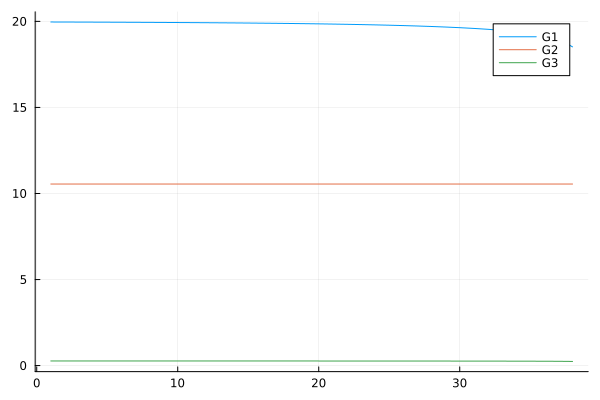

In [308]:
d1 = map(y->y[1],filter(x->length(x) > 0,data_points))

plot(map(x->x[1],d1),label = "G1")
plot!(map(x->x[2],d1),label = "G2")
plot!(map(x->x[3],d1),label = "G3")

In [239]:
import DifferentialEquations as DE

const Nc = 100
const Ng = 3
const L = 1.
const θ = 5.
const c0 = 10.
const λm = 0.4

const tissue = range(0,L,length = Nc)

mor(x) = c0*exp(-x/λm)

# σ(I) = 1/(1+exp(θ-θ*I))  # σ(0.) > 0 ?

 # σ(0.) > 0 ?

# MOL: u_{j}(t) = u(x_j,t) where x_j = j*dx

function gene_regulation_1d!(dg,g,p,t)

    w, λg = p

    @inbounds for j in 1:Nc
        x = tissue[j]
        dg[1,j] = σ(w[1,1]*g[1,j]+ w[1,2]*g[2,j] + w[1,3]*g[3,j] + w[1,4]*mor(x)) - λg[1]*g[1,j]
        dg[2,j] = σ(w[2,1]*g[1,j]+ w[2,2]*g[2,j] + w[2,3]*g[3,j] + w[2,4]*mor(x)) - λg[2]*g[2,j]
        dg[3,j] = σ(w[3,1]*g[1,j]+ w[3,2]*g[2,j] + w[3,3]*g[3,j] + w[3,4]*mor(x)) - λg[3]*g[3,j]
    end
    
end

function gene_regulation_single!(dg,g,p,t)

    w, λg, m = p

    dg[1] = σ(w[1,1]*g[1]+ w[1,2]*g[2] + w[1,3]*g[3] + w[1,4]*m) - λg[1]*g[1]
    dg[2] = σ(w[2,1]*g[1]+ w[2,2]*g[2] + w[2,3]*g[3] + w[2,4]*m) - λg[2]*g[2]
    dg[3] = σ(w[3,1]*g[1]+ w[3,2]*g[2] + w[3,3]*g[3] + w[3,4]*m) - λg[3]*g[3]

end


function init_gene_regulation_1d(start_conc)
    return start_conc .* ones(Ng,Nc)
end


init_gene_regulation_1d (generic function with 1 method)

In [279]:
dg = zeros(3)
g = sol.u[end][:,39]
gene_regulation_single!(dg,g,(w,[0.05,0.05,0.05],morphogen_gradient[39][end]),0.)

dg

3-element Vector{Float64}:
 -4.5349174068731735e-11
  3.6637359812630166e-15
 -3.3331627388721863e-12

In [282]:
zero_sys(g,morphogen_gradient[39])

3-element Vector{Float64}:
 4.5349174068731735e-11
 3.6637359812630166e-15
 3.3331627388721863e-12

In [281]:
p

14-element Vector{Float64}:
  0.567407
  0.0
  0.166203
 -1.40317
  0.00521438
 -0.71488
 -0.171388
  0.0
  0.0
  1.51779
  0.0
  0.0
  0.05
 10.0

In [262]:
# mor(tissue[39])

zero_sys(sol.u[end][:,39],p)

3-element Vector{Float64}:
 0.6808296241588274
 3.6637359812630166e-15
 3.3331627388721863e-12

In [180]:
p_de = (w,0.05)

g0 = init_gene_regulation_1d(0.01)
    
grn = DE.ODEProblem(gene_regulation_1d!,g0,(0,Inf),p_de)

sol = DE.solve(grn,DE.AutoTsit5(DE.RadauIIA5()),isoutofdomain=(u,p,t) -> any(x -> x < 0, u), reltol = 1e-7,abstol = 1e-11,callback = DE.TerminateSteadyState(1e-10,1e-6),maxiters = 1e5, verbose = false, save_everystep = false)

retcode: Terminated
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
   0.0
 700.3995229734544
u: 2-element Vector{Matrix{Float64}}:
 [0.01 0.01 … 0.01 0.01; 0.01 0.01 … 0.01 0.01; 0.01 0.01 … 0.01 0.01]
 [19.963404813616805 19.960912386173717 … 0.027225606400915616 0.027098004803123858; 10.549247507795332 10.549247507795332 … 10.549247507795332 10.549247507795332; 0.2690446560252668 0.268993996675768 … 0.08687480094473854 0.08687431839392797]

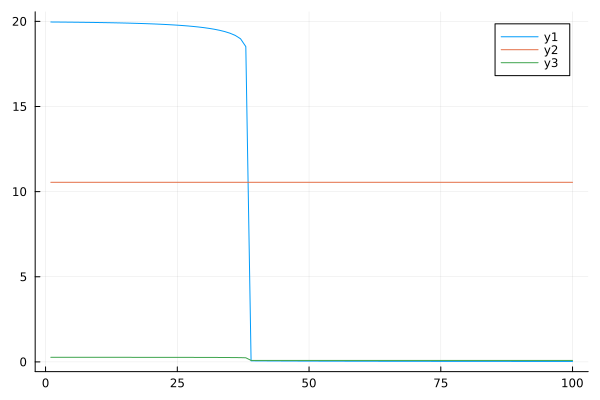

In [241]:
plot(sol.u[end][1,:])
plot!(sol.u[end][2,:])
plot!(sol.u[end][3,:])

In [182]:
@benchmark DE.solve(grn,DE.AutoTsit5(DE.RadauIIA5()),isoutofdomain=(u,p,t) -> any(x -> x < 0, u), reltol = 1e-7,abstol = 1e-11,callback = DE.TerminateSteadyState(1e-10,1e-6),maxiters = 1e5, verbose = false, save_everystep = false)

BenchmarkTools.Trial: 1523 samples with 1 evaluation.
 Range (min … max):  3.113 ms …  11.995 ms  ┊ GC (min … max): 0.00% … 73.06%
 Time  (median):     3.168 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.281 ms ± 938.522 μs  ┊ GC (mean ± σ):  3.18% ±  8.00%

  █▃                                                           
  ██▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅ ▇
  3.11 ms      Histogram: log(frequency) by time      11.4 ms <

 Memory estimate: 3.63 MiB, allocs estimate: 428.

In [171]:
@benchmark data_points = solve(
    GRN,
    solutions(S);
    start_parameters =  p,
    target_parameters = morphogen_gradient,
    transform_result = (r,p) ->get_valid_solutions(r,p)
)

BenchmarkTools.Trial: 43 samples with 1 evaluation.
 Range (min … max):  114.125 ms … 124.934 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     115.935 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   116.902 ms ±   2.595 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁ ▄▁ ▄▁▁▁▁█▁▁      ▁▁                                          
  █▁██▆████████▁▆▁▆▆▁██▁▁▆▁▁▁▁▁▆▆▆▁▁▁▁▁▁▆▁▁▁▆▁▁▁▁▁▁▆▁▁▁▆▁▁▁▁▁▁▆ ▁
  114 ms           Histogram: frequency by time          125 ms <

 Memory estimate: 21.23 MiB, allocs estimate: 115705.

In [172]:
# 0.567407  -1.40317     -0.171388  1.51779
# 0.0        0.00521438   0.0       0.0
# 0.166203  -0.71488      0.0       0.0

In [173]:
dg = zeros(3,Nc)

3×500 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [242]:
gene_regulation_1d!(dg,sol.u[end],p_de,0.)

In [243]:
all(sum(dg, dims = 1) .< 1e-10)

true

In [160]:
all(dg .< 1e-8)

true

In [176]:
ind = []
for i in 1:3
    for j in 1:Nc
        if dg[i,j] > 1e-10
            push!(ind,(i,j))
        end
    end
end

In [177]:
ind

Any[]

In [178]:
dg[3,189]

4.2396184653237245e-11